**Script name** : Local Planner

**Description** : Multi-agent payload transport global planner based on APF.

**Author**      : Swapnil Kalhapure

**Email**       : kalhapure.swapnil@gmail.com

## Imports

In [1]:
import rospy
import cv2
import tf2_ros
import tf2_geometry_msgs
import numpy as np
import matplotlib.pyplot as plt
from nav_msgs.msg import Odometry
from nav_msgs.msg import Path
from nav_msgs.msg import OccupancyGrid
from geometry_msgs.msg import Twist
from scipy.ndimage.morphology import distance_transform_edt as bwdist
from scipy.ndimage.morphology import grey_dilation
from IPython.display import display, clear_output

## Global variables

In [2]:
res_remap = 0.04

map_x = 0.0
map_y = 0.0
map_org_x = 0.0
map_org_y = 0.0
map_res = 0.0

mapdata = None
orgmapdata = None

globalpath = []
current_odom = None

## Helper functions

In [3]:
def meters2grid(pose_m):
    pose_on_grid = np.array((np.array(pose_m) - [map_org_x, map_org_y])/ map_res)
    pose_on_grid[1] = map_y - pose_on_grid[1] 
    return pose_on_grid

In [4]:
def grid2meters(pose_grid):
    x = pose_grid[0] * (map_res) + map_org_x 
    y = (map_y - pose_grid[1]) * (map_res) + map_org_y 
    a = []
    a.append(float(x))
    a.append(float(y))
    return a

## Controller

In [5]:
class local_region:
    def __init__(self, origin_x, origin_y, width=200):
        self.org_x = origin_x
        self.org_y = origin_y
        self.data = None
        self.force = None
        self.attractive = None
        self.repulsive = None
        self.data = mapdata[origin_y-width:origin_y+width,origin_x-width:origin_x+width]
        
    def set_map_data(self,data):
        self.data = data
        
    def get_map_data(self):
        return self.data
    
    def get_origin(self):
        return [self.org_x,self.org_y]
    
    def compute_map_repulsive_force(self,influence_radius = 7, repulsive_coef = 100):
        img = np.zeros((400, 400), np.uint8)
        bdist = bwdist(self.data==255)
        bdist2 = (bdist/100.) + 1
        repulsive = repulsive_coef*((1./bdist2 - 1./influence_radius)**2)
        repulsive [bdist2 > influence_radius] = 0
        self.repulsive = repulsive
        return repulsive
    
    def compute_attractive_force(self, goal = [50,50],attractive_coef = 1./100):
        [x, y] = np.meshgrid(np.arange(self.data.shape[1]), np.arange(self.data.shape[0]))
        attractive = attractive_coef * ( (x - goal[0])**2 + (y - goal[1])**2 )
        self.attractive = attractive
        return attractive
    
    def compute_pallet_force(self, goal = [50,50], repulsive_coef = 1./10 ):
        [px, py] = np.meshgrid(np.arange(self.data.shape[0]/4), np.arange(self.data.shape[1]/4))
        attractive =  -repulsive_coef * ((px - self.data.shape[0]/8)**2 + (py - self.data.shape[1]/8)**2 )
        [x, y] = np.meshgrid(np.ones(self.data.shape[0]), np.ones(self.data.shape[1]))
        x = x + np.min(attractive)
        y = y + np.min(attractive)
        whole = x + y
        whole[int(goal[0]-self.data.shape[0]/8):int(goal[0]+self.data.shape[0]/8),
              int(goal[1]-self.data.shape[1]/8):int(goal[1]+self.data.shape[1]/8)] = attractive
        whole = cv2.blur(whole,(100,100))
        return whole,attractive
    
    def compute_forces(self,goal = [50,50],pallet_goal=[100,100], influence_radius = 7, repulsive_coef = 100, attractive_coef = 1./100):
        repulsive = self.compute_map_repulsive_force(influence_radius,repulsive_coef)
        attractive = self.compute_attractive_force(goal,attractive_coef)
        pallet_repulsive,po =  self.compute_pallet_force(pallet_goal,repulsive_coef=.25)
        self.force =  repulsive + attractive + pallet_repulsive
        return self.force 
    

    def visualize_forces (self):
        skip = 5
        [x_m, y_m] = np.meshgrid(np.linspace(1, 400,400), np.linspace(1, 400,400))
        [gy, gx] = np.gradient(self.force);
        gx = -gx
        q_stack = x_m[::skip, ::skip], y_m[::skip, ::skip], gx[::skip, ::skip], gy[::skip, ::skip]
        plt.figure(figsize=(7,7))
        plt.imshow(self.data)
        plt.quiver(x_m[::skip, ::skip], y_m[::skip, ::skip], gx[::skip, ::skip], gy[::skip, ::skip])
        return plt
    
    def gradient_planner (self, start_coords):
        [gy, gx] = np.gradient(-self.force);
        route = np.array([np.array(start_coords)])
        ix = 0
        iy = 0
        max_itr = 0
        while(((ix < len(gx)-2) and (ix < len(gy)-2)) and max_itr < 1000):
            current_point = route[-1,:];
            ix = int( current_point[1] )
            iy = int( current_point[0] )
            vx = gx[ix, iy]
            vy = gy[ix, iy]
            dt = 1 / np.linalg.norm([vx, vy]);
            next_point = current_point + dt*np.array( [vx, vy] );
            route = np.vstack( [route, next_point] ); 
            max_itr = max_itr + 1 
        return route

## ROS Code

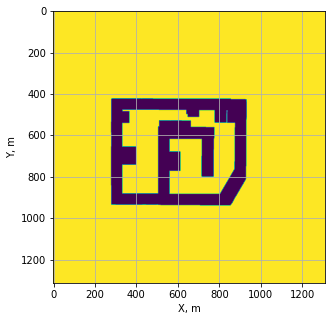

In [6]:
def map_callback(data):
    global mapdata
    global orgmapdata
    global map_x
    global map_y
    global map_org_x
    global map_org_y
    global map_res
    global res_remap
    
    map_x = data.info.width
    map_y = data.info.height
    map_org_x = data.info.origin.position.x
    map_org_y = data.info.origin.position.y
    map_res = data.info.resolution
    
    orgmapdata = np.asarray(data.data).reshape(data.info.height,data.info.width).astype(np.uint8)
    orgmapdata = np.flip(orgmapdata,0)
    mapdata = orgmapdata
    mapdata = np.where(mapdata<254,mapdata,0)
    mapdata = grey_dilation(mapdata,size=(int(res_remap*map_y),int(res_remap*map_x)))
    mapdata = np.invert(mapdata)
    mapdata = cv2.threshold(mapdata, 200, 255, cv2.THRESH_BINARY)[1]

    plt.figure(figsize=(5,5))
    plt.grid()
    plt.imshow(mapdata)
    plt.xlabel('X, m')
    plt.ylabel('Y, m')
    plt.show() 


def path_callback(data):
    global mapdata
    global globalpath
    print("Got the Global path")
    globalpath = []
    x = []
    y = []
    for i in range(len(data.poses)):
        ans = meters2grid((data.poses[i].pose.position.x,
                                       data.poses[i].pose.position.y))
        x.append(int(ans[0]))
        y.append(int(ans[1]))
    globalpath.append(x)
    globalpath.append(y)
    globalpath = np.flip(globalpath,1)
    plt.figure(figsize=(5,5))
    plt.imshow(mapdata)
    plt.grid(True)
    plt.plot(globalpath[0],globalpath[1],"bo--")
    plt.show()

def odom_callback(data):
    global current_odom
    current_odom = data

rospy.init_node('LocalPlanner', anonymous=True)
rospy.Subscriber("/map", OccupancyGrid, map_callback)
rospy.Subscriber("/global_path", Path, path_callback)
rospy.Subscriber("/jackal0/odometry/local_filtered", Odometry, odom_callback)
path_pub = rospy.Publisher('/jackal0/cmd_vel', Twist, queue_size=10)

In [15]:
p = True
t = 0
path_goal_pose = [globalpath[0][t],globalpath[1][t]]
pallet_pose = [300,300]
while p:
    co = meters2grid([current_odom.pose.pose.position.x,current_odom.pose.pose.position.y]).astype(np.uint16)
    a = local_region(co[0],co[1])
    r = a.compute_forces(goal = path_goal_pose, 
                         pallet_goal = pallet_pose,
                         influence_radius = 2, 
                         repulsive_coef = 2200, 
                         attractive_coef = 1./100)
    
    test = a.visualize_forces()
    route = a.gradient_planner(robot_pose)
    test.plot(route[:,0],route[:,1],"bo--")
    test.plot(robot_pose[0],robot_pose[1],"go")
    test.plot(pallet_pose[0],pallet_pose[1],"ro")
    test.show()
    
    display(test)
    clear_output(wait = True)

KeyboardInterrupt: 

## Test code

co = meters2grid([current_odom.pose.pose.position.x,current_odom.pose.pose.position.y]).astype(np.uint16)
a = local_region(co[0],co[1])
r = a.compute_forces(goal=[50,50],pallet_goal = [50,50],influence_radius = 2, 
                                                        repulsive_coef = 2200, 
                                                        attractive_coef = 1./100)
test = a.visualize_forces()
test.show()

tt = 2
a = local_region(globalpath[0][tt],globalpath[1][tt])
path_goal_pose = [200,800]
pallet_pose = [300,300]
robot_pose = [200,200]
r = a.compute_forces(goal=path_goal_pose,pallet_goal = pallet_pose,influence_radius = 2, 
                                                        repulsive_coef = 2200, 
                                                        attractive_coef = 1./100)
test = a.visualize_forces()
route = a.gradient_planner(robot_pose)
test.plot(route[:,0],route[:,1],"bo--")
test.plot(robot_pose[0],robot_pose[1],"go")
test.plot(pallet_pose[0],pallet_pose[1],"ro")
test.show()

## Garbage

plt.imshow(r)
plt.colorbar()

[x, y] = np.meshgrid(np.arange(50), np.arange(50))
ff = ((y - 25)**2) + ((x - 25)**2)

[px, py] = np.meshgrid(np.zeros(200), np.zeros(200))
fff= px+py

fff[(int((fff.shape[0]/2)-(ff.shape[0]/2))):int(((fff.shape[0]/2)+(ff.shape[0]/2))),
    (int((fff.shape[1]/2)-(ff.shape[1]/2))):int(((fff.shape[1]/2)+(ff.shape[1]/2)))]=ff
plt.imshow(fff)

[x, y] = np.meshgrid(np.arange(100), np.arange(100))
a = ((x - 50)**2) + ((y - 50)**2)
plt.imshow(a)
np.max(a)

np.vstack(a[:,0]).reshape(100)

[tx, ty] = np.meshgrid(np.ones(300), np.ones(300))

tx = tx*np.max(a)
tx[0:100,0:100]=5
tx[0:100,200:300]=5000
tx[200:300,0:100]=5000
tx[200:300,200:300]=5000
tx[100:200,0:100] = np.vstack(a[:,0])
tx[100:200,200:300] = np.vstack(a[:,0])
tx[0:100,100:200] = np.vstack(a[:,0]).reshape(100)
tx[200:300,100:200] = np.vstack(a[:,0]).reshape(100)
tx[100:200,100:200] = a

plt.imshow(cv2.blur(tx,(10,10)))
plt.colorbar()

skip= 5
[x_m, y_m] = np.meshgrid(np.linspace(1, 300,300), np.linspace(1, 300,300))
[gy, gx] = np.gradient(cv2.blur(tx,(10,10)));
gx = gx
q_stack = x_m[::skip, ::skip], y_m[::skip, ::skip], gx[::skip, ::skip], gy[::skip, ::skip]
plt.figure(figsize=(15,15))
plt.imshow(tx)
plt.colorbar()
plt.quiver(x_m[::skip, ::skip], y_m[::skip, ::skip], gx[::skip, ::skip], gy[::skip, ::skip])

[px, py] = np.meshgrid(np.arange(50), np.arange(50))

b = ((px - 25)**2) + ((py - 25)**2)

plt.imshow(b)
plt.colorbar()